# Header

In [12]:
import numpy as np
import healpy as hp
import os, sys
import matplotlib.pyplot as plt
from os.path import join as opj

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 18})


from astropy.io import fits
from lenscarf.iterators.statics import rec
import plancklens
from plancklens import utils, qresp
from plancklens.sims import planck2018_sims

from lenscarf.utils import cli

from cmbs4 import sims_08b
fg = '00'
sims_cmbs4May  = sims_08b.caterinaILC_May12(fg)
sims_cmbs4Sep  = sims_08b.caterinaILC_Sep12(fg)

import component_separation.transformer as trsf
from component_separation.cs_util import Config
csu = Config('Planck')
colors = csu.CB_color_cycle
colors_lt = csu.CB_color_cycle_lighter

nside = 2048
lmax_cl = 2048
lmax_plot = 195
lmax_qlm = 2500
lmax_mask = 4096

nlevels = [1.2, 1.5, 1.7, 2., 2.3, 5.0, 10.0, 50.0]
simids = np.arange(0,500)

import hashlib
edges_1 = np.array([2, 30, 80, 200, 500, 4096])
edges_2 = np.array([2,20,40,60,80,100,120,140,160,180,200, 300, 500, 700, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 5000])
bk14_edges = np.array([2,55,90,125,160,195,230,265,300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000]) # BK14 is [ 55  90 125 160 195 230 265 300], from bk14 = h5py.File('/global/homes/s/sebibel/notebooks/CMBS4/datasharing/likedata_BK14.mat', 'r')['likedata']['lval'][0,:]
ioreco_edges = np.array([2,30,200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])
cmbs4_edges = np.array([2, 30, 60, 90, 120, 150, 180, 200, 300, 500, 700, 1000, 1500, 2000, 3000, 4000, 5000])

iteration = [0,12]

ll = np.arange(0,lmax_plot+1,1)
binspace = 5
scale_uk = (2 * ll + 1) * ll**2 * (ll + 1)**2
scale_ps = ll*(ll+1)/(2*np.pi)
label_scale_ps = r'$\frac{\ell(\ell+1)}{2 \pi}$'
label_scale_lp = r'$\frac{\ell^2(\ell+1)^2}{2 \pi}$'
scale_lp = ll**2 * (ll + 1)**2 * 1e7 / (2 * np.pi)

psl = r'$\frac{l(l+1)}{2\pi}C_\ell \/ [\mu K^2]$'

MSC: reverting to standard healpy


In [13]:
smica_mask = np.load('/global/homes/s/sebibel/data/mask/psmaskP_2048_gmaskP_apodized.npy')
lens_mask = np.load('/global/homes/s/sebibel/data/mask/PR3vJan18_temp_lensingmask_gPR2_70_psPR2_143_COT2_smicadx12_smicapoldx12_psPR2_217_sz_apodized.npy')
bk14_mask = hp.read_map('/global/homes/s/sebibel/data/mask/bk14_mask_gal_n0512.fits')
cmbs4_mask = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/foreground_cleaned_maps/08b.%s_umilta_210511/'%fg + '/ILC_mask_08b_smooth_30arcmin.fits'))
juliens_mask = sims_08b.get_nlev_mask(2.)

def getfn_blm_lensc(simidx, fg, it):
    '''Lenscarf output using Catherinas E and B maps'''
    if it==12:
        return '/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/lt_recons/08b.%02d_sebibel_210708_ilc_iter/blm_csMAP_obd_scond_lmaxcmb4000_iter_%03d_elm011_sim_%04d.fits'%(int(fg),it,simidx)
    elif it==0:
        return '/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_%s_lmax4000/zb_terator_p_p_%04d_nofg_OBD_solcond_3apr20/ffi_p_it0/blm_%04d_it0.npy'%(fg,simidx,simidx)

def get_teblm_ffp10(simidx):
    '''Pure BB-lensing from ffp10''' 
    ret = 1e6 * hp.read_alm('/project/projectdirs/cmb/data/generic/cmb/ffp10/mc/scalar/ffp10_lensed_scl_cmb_000_alm_mc_%04d.fits'%simidx, hdu=(1,2,3))
    return ret

def getfn_qumap_cs(simidx):
    '''Component separated polarisation maps lm, i.e. lenscarf input'''
    if simidx>=200:
        return sims_cmbs4Sep.get_sim_pmap(simidx+200)
    else:
        return sims_cmbs4May.get_sim_pmap(simidx)

def getfn_plm_lensc(simidx, iteration):
    '''lensing potential for simulation index and iteration'''
    return np.array([rec.load_plms('/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_00_lmax4000/zb_terator_p_p_%04d_nofg_OBD_solcond_3apr20'%simid, iteration) for simid in simids])


def getfn_blm_lensc_special(simidx, fg, it, blm_suffix):
    '''Lenscarf output using Catherinas E and B maps'''
    if blm_suffix == '':
        if it==12:
            rootstr = '/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/lt_recons/'
            if fg == '00':
                return rootstr+'08b.%02d_sebibel_210708_ilc_iter/blm_csMAP_obd_scond_lmaxcmb4000_iter_%03d_elm011_sim_%04d.fits'%(int(fg), it, simidx)
            elif fg == '07':
                return rootstr+'/08b.%02d_sebibel_210910_ilc_iter/blm_csMAP_obd_scond_lmaxcmb4000_iter_%03d_elm011_sim_%04d.fits'%(int(fg), it, simidx)
            elif fg == '09':
                return rootstr+'/08b.%02d_sebibel_210910_ilc_iter/blm_csMAP_obd_scond_lmaxcmb4000_iter_%03d_elm011_sim_%04d.fits'%(int(fg), it, simidx)
        elif it==0:
            return '/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_%s_lmax4000/zb_terator_p_p_%04d_nofg_OBD_solcond_3apr20/ffi_p_it0/blm_%04d_it0.npy'%(fg, simidx, simidx)
        
    else:
        rootstr = '/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_%s_lmax4000/zb_terator_p_p_%04d_nofg_OBD_solcond_3apr20/'%(fg, simidx)
        return rootstr + 'ffi_p_it%s%s/blm%s_%04d_it%d.npy'%(it, blm_suffix, blm_suffix, simidx, it)

def clamp(val, minimum=0, maximum=255):
    if val < minimum:
        return minimum
    if val > maximum:
        return maximum
    return val

def colorscale(hexstr, scalefactor):
    """
    Scales a hex string by ``scalefactor``. Returns scaled hex string.

    To darken the color, use a float value between 0 and 1.
    To brighten the color, use a float value greater than 1.

    >>> colorscale("#DF3C3C", .5)
    #6F1E1E
    >>> colorscale("#52D24F", 1.6)
    #83FF7E
    >>> colorscale("#4F75D2", 1)
    #4F75D2
    """

    hexstr = hexstr.strip('#')

    if scalefactor < 0 or len(hexstr) != 6:
        return hexstr

    r, g, b = int(hexstr[:2], 16), int(hexstr[2:4], 16), int(hexstr[4:], 16)

    r = clamp(r * scalefactor)
    g = clamp(g * scalefactor)
    b = clamp(b * scalefactor)

    return "#%02x%02x%02x" % (int(r), int(g), int(b))

In [14]:
import matplotlib.colors as mcolors
colors1 = plt.cm.Greys(np.linspace(0., .5, 128))
colors2 = [plt.cm.Blues(np.linspace(0.6, 1., 128)), plt.cm.Reds(np.linspace(0.8, 1., 128)), plt.cm.Wistia(np.linspace(0.4, 1., 128)), plt.cm.Greens(np.linspace(0.6, 1., 128))]
mymap = []
nlevels_loc = [1.2, 2., 5.0, 50.0]
for ni, n in enumerate(nlevels_loc):
    colors2[ni][:,-1] = 0.5
    colors_loc = np.vstack((colors1, colors2[ni]))
    mymap.append(mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_loc))

In [15]:
def get_ms(dat, binspace=5, bin_multipole=False):
    x = edges_center
    if bin_multipole:
        return get_weighted_avg(np.mean(dat, axis=0), np.std(dat, axis=0), binspace=binspace)
    else:
        return x, np.mean(dat, axis=0), np.std(dat, axis=0)

def get_weighted_avg(mean, std, binspace):
    lscan = np.arange(0,len(mean),binspace)
    w_average = np.zeros(shape=int(round((len(mean)/binspace))))
    w_variance = np.zeros(shape=int(round((len(mean)/binspace))))
    for n in range(len(w_average)):
        w_average[n] = np.average(mean[n*binspace:(n+1)*binspace], weights=std[n*binspace:(n+1)*binspace])
        w_variance[n] = np.average(std[n*binspace:(n+1)*binspace])
        
        # w_variance[n] = np.average((mean-w_average[n])[n*binspace:(n+1)*binspace]**2, weights=std[n*binspace:(n+1)*binspace])
    return lscan, w_average, w_variance

def bandpass_alms(alms, lmin, lmax=None):
    """
    lmin: minimum multipole to keep in alms
    lmax: maximimum multipole to keep in alms
    """
    
    if len(alms) == 3:
        out = np.zeros(alms.shape, dtype=complex)
        for idx, _alms in enumerate(alms):
            out[idx] = bandpass_alms(_alms, lmin, lmax=lmax)
        return out
    
    lmax_in_alms = hp.Alm.getlmax(len(alms))
    if lmax is None:
        lmax = lmax_in_alms
    else:
        assert isinstance(lmax, int), "lmax should be int: {}".format(lmax)
        assert lmax <= lmax_in_alms, "lmax exceeds lmax in alms: {} > {}".format(lmax, lmax_in_alms)
    
    fl = np.zeros(lmax_in_alms + 1, dtype=float)
    fl[lmin:lmax+1] = 1
    
    return hp.almxfl(alms, fl)

In [16]:
cls_path = opj(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))
clc_templ = cls_len['bb']

# Data
## CMB-S4 - B

In [17]:
beam = 2.3
lmax_transf = 4000
transf = hp.gauss_beam(beam / 180. / 60. * np.pi, lmax=lmax_transf)
rhits = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/08b/rhits/n2048.fits'))
# qumap_cs = np.array([getfn_qumap_cs(simid) for simid in simids])
# qumap_cs.shape
# hp.mollview(qumap_cs[0,0]*np.round(cmbs4_mask), min=-19, max= 19, cmap='PuOr', title='input Q')

## ffp10 - B and P
 * Bmaps come in different sizes, shape need to match for crosscorrelation
 * Fiducial data comes without the transferfunction -> apply

In [18]:
cls_path = opj(os.path.dirname(plancklens.__file__), 'data', 'cls')
cls_len = utils.camb_clfile(opj(cls_path, 'FFP10_wdipole_lensedCls.dat'))
clc_templ = cls_len['bb']

# Maps

In [19]:
rotation = 0
lonra = np.array([-55,55])+40
latra = np.array([-100,-55])+25

In [20]:
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import ndimage
from matplotlib import cm
from scipy import interpolate

In [21]:
colors2 = [plt.cm.Blues(np.linspace(0.6, 1., 128)), plt.cm.Reds(np.linspace(0.8, 1., 128)), plt.cm.Wistia(np.linspace(0.4, 1., 128)), plt.cm.Greens(np.linspace(0.6, 1., 128))]
nlevels_loc = [1.2, 2., 5.0, 50.0]
for ni, n in enumerate(nlevels_loc):
    colors2[ni][:,-1] = 0.5
for ni, n in enumerate(nlevels_loc):
    if ni==0:
        colors_loc = colors2[ni]
    else:
        colors_loc = np.vstack((colors_loc, colors2[ni]))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_loc)
matplotlib.rcParams.update({'font.size': 18})

import matplotlib.colors as mcolors
colors2 = [plt.cm.Blues(np.linspace(0.6, 1., 128)), plt.cm.Reds(np.linspace(0.8, 1., 128)), plt.cm.Wistia(np.linspace(0.4, 1., 128)), plt.cm.Greens(np.linspace(0.6, 1., 128))]
mymap = []
nlevels_loc = [1.2, 2., 5.0, 50.0]
for ni, n in enumerate(nlevels_loc):
    colors2[ni][:,-1] = 0.5
for ni, n in enumerate(nlevels_loc):
    if ni==0:
        colors_loc = colors2[ni]
    else:
        colors_loc = np.vstack((colors_loc, colors2[ni]))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_loc)

## Noise level

In [5]:
import matplotlib.colors as mcolors
rotation = 0
lonra = np.array([-55,55])+40
latra = np.array([-100,-55])+25

In [6]:
rhits = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/expt_xx/08b/rhits/n2048.fits'))
THIS_CENTRALNLEV_UKAMIN = 0.42
pixlev = THIS_CENTRALNLEV_UKAMIN / (np.sqrt(hp.nside2pixarea(2048, degrees=True)) * 60.)
print("Pmap center pixel pol noise level: %.2f"%(pixlev * np.sqrt(hp.nside2pixarea(nside, degrees=True)) * 60.))

Pmap center pixel pol noise level: 0.42


0.030145883560180664

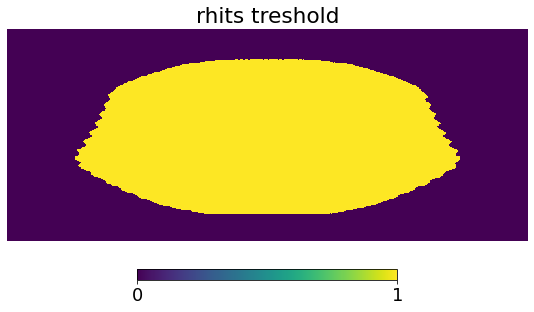

In [17]:
ratio = 5

rhits_tresh = np.where(rhits < 1. / ratio, 0., 1.)  *(~np.isnan(rhits))
hpmap = hp.cartview(rhits_tresh, lonra=lonra, latra=latra, title='rhits treshold', return_projected_map=True)
np.sum(rhits_tresh)/len(rhits)

(400, 800)


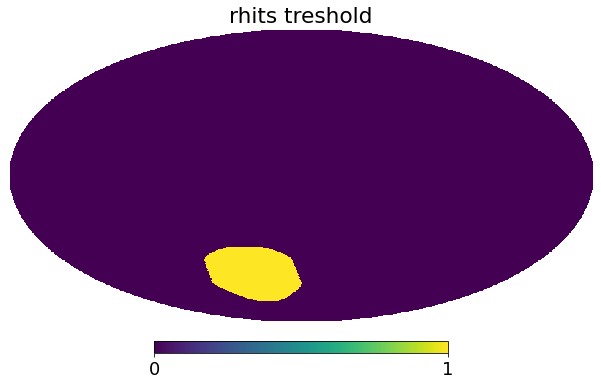

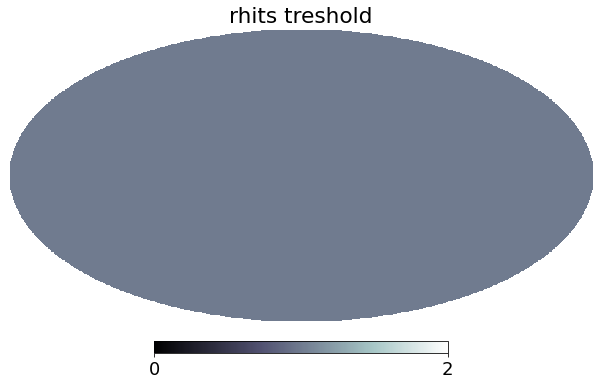

In [50]:
hpmap = hp.mollview(rhits_tresh,  title='rhits treshold', return_projected_map=True)
print(hpmap.shape)
hpmap_neval = hp.mollview(np.ones_like(rhits_tresh),  title='rhits treshold', return_projected_map=True, cmap='bone')

In [20]:
from healpy.projector import CartesianProj
hpmap = rhits_tresh
Npts = 1000
P = CartesianProj(rot = [0,0,0.],lonra=lonra, latra=latra, xsize=Npts, ysize=Npts)
P.set_flip('astro')
projmap = P.projmap(hpmap, lambda x, y, z: hp.vec2pix(hp.npix2nside(len(hpmap)), x, y, z))

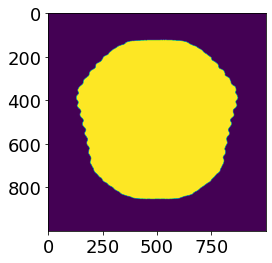

In [21]:
plt.imshow(projmap)

In [22]:
colors2 = [plt.cm.Blues(np.linspace(0.3, 0.8, 128)), plt.cm.Reds(np.linspace(0.3, .8, 128)), plt.cm.Wistia(np.linspace(0.3, .8, 128)), plt.cm.Greens(np.linspace(0.3, .8, 128)), plt.cm.Greys(np.linspace(0.5, 1.0, 128))]
mymap = []
nlevels_loc = [1.2, 2., 5.0, 50.0]
for ni, n in enumerate(nlevels_loc):
    colors2[ni][:,-1] = 0.5
for ni, n in enumerate(nlevels_loc):
    if ni==0:
        colors_loc = colors2[ni]
    else:
        colors_loc = np.vstack((colors_loc, colors2[ni]))
mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors_loc)

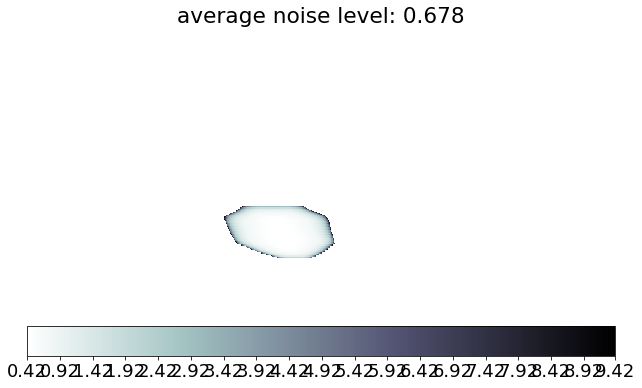

In [40]:
ratio = 500.0
ninv = cinv_p_OBD_nobmarg.chain.n_inv_filt.n_inv[0]

noisemap = np.where(rhits < 1. / ratio, 0., ninv)  *(~np.isnan(rhits)) # ninv[rhits < 1. / ratio] *(~np.isnan(rhits))#1. / pixlev ** 2 * rhits_tresh
npix = len(noisemap)
nlev_p = np.sqrt(4. * np.pi / npix / np.sum(noisemap) * len(np.where(noisemap != 0.0)[0])) * 180. * 60. / np.pi
nlp = np.sqrt(4. * np.pi / npix / noisemap) * 180. * 60. / np.pi
nmax = np.max(nlp[nlp!=np.inf])
# noiselevelmap = hp.cartview(np.sqrt(4. * np.pi / npix / noisemap) * 180. * 60. / np.pi, lonra=lonra, latra=latra, title='average noise level: %.3f'%(nlev_p), cmap='bone_r', cbar = False, return_projected_map=True)
noiselevelmap = hp.mollview(np.sqrt(4. * np.pi / npix / noisemap) * 180. * 60. / np.pi, title='average noise level: %.3f'%(nlev_p), cmap='bone_r', cbar = False, return_projected_map=True)

fig = plt.gcf()
ax = plt.gca()
image = ax.get_images()[0]

cmap = fig.colorbar(image, ax=ax, ticks = np.arange(0.42,nmax+0.2,0.5), orientation='horizontal')

0.0 180.0 -180.0 180.0


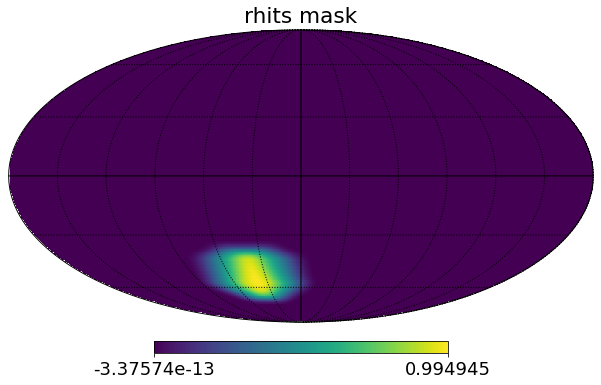

In [25]:
cmbs4_mask = np.nan_to_num(hp.read_map('/project/projectdirs/cmbs4/awg/lowellbb/reanalysis/foreground_cleaned_maps/08b.%s_umilta_210511/'%fg + '/ILC_mask_08b_smooth_30arcmin.fits'))
ratio = 500
tresh = np.where(rhits < 1. / ratio, 0., 1.)  *(~np.isnan(rhits))
# proj_map = hp.cartview(cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, title='rhits mask', rot=[-rotation,-rotation], return_projected_map=True)
proj_map = hp.mollview(cmbs4_mask,  title='rhits mask', rot=[-rotation,-rotation], return_projected_map=True)
hp.graticule()

0 [0.98823529 0.67154171 0.56053825 1.        ]
1 [0.29098039 0.5945098  0.78901961 1.        ]
2 [0.73647059 0.08       0.10117647 1.        ]
3 [1.         0.80862745 0.04078431 1.        ]
4 [0.29490196 0.69019608 0.38431373 1.        ]
5 [0.25098039 0.25098039 0.25098039 1.        ]
[0.43, 0.59, 2.96]


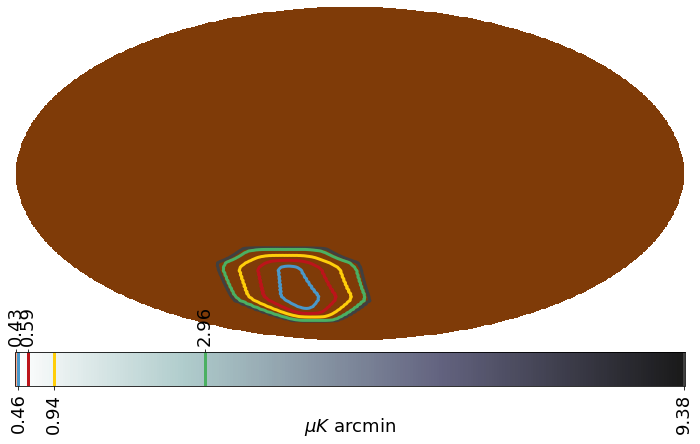

In [54]:
col = np.array([plt.cm.Reds(np.linspace(0.3, .6, 128)), plt.cm.Blues(np.linspace(0.6, 1., 128)), plt.cm.Reds(np.linspace(0.8, 1., 128)), plt.cm.Wistia(np.linspace(0.4, 1., 128)), plt.cm.Greens(np.linspace(0.6, 1., 128)), plt.cm.Greys(np.linspace(0.8, 1.0, 128))])


fig = plt.figure(figsize=(12,10))
a = plt.imshow(noiselevelmap, cmap='bone_r', origin='lower', alpha=0.9)
plt.imshow(hpmap_neval,  origin='lower', cmap='PuOr')
FR = proj_map
X, Y = np.mgrid[0:400:400j, 0:800:800j]
plt.contour(Y, X, FR, levels=[1/500, 1/50, 1/5, 1/2,1/1.2, 1/1.005], colors=col[::-1,0,:], alpha=1.0, linewidths=3, cbar=True)

ax = plt.gca()
ax.axis('off')

import matplotlib.colors as mlcolors
valmax = np.max(noiselevelmap[noiselevelmap!=np.inf])-0.01
allticks = [0.43, 0.46, 0.59, 0.94, 2.96, float('%.2f'%valmax)]
cbar = fig.colorbar(a, orientation='horizontal',
                    ticks = allticks,
                    pad = 0.02)
cbar.set_label('$\mu K$ arcmin', verticalalignment='bottom')
for ticki, tick in enumerate(allticks):
    print(ticki, col[:,0,:][ticki])
    cbar.ax.vlines(tick,0,1, color=col[:,0,:][ticki], lw=3)

labels = allticks[1:][::2]

cbar.set_ticks(labels)
cbar.ax.set_xticklabels(labels, rotation=90)


ax_t = cbar.ax.secondary_xaxis('top')
labels = allticks[::2]
print(labels)
ax_t.set_ticks(labels)
ax_t.set_xticklabels(labels, rotation=90)
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/masks.pdf', bbox_inches='tight')

### Masks

In [29]:
int_mask = np.array(np.round(cmbs4_mask+0.49),dtype=np.int)

Text(0.5, 0, 'Noise ratio treshold')

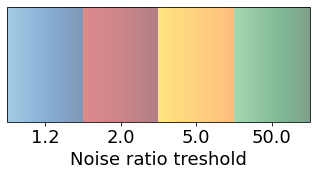

In [40]:
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.05)

a = np.array([[0,1,2,3,4,5,6,7,8]])
img = cax.imshow(a, cmap=mymap)
plt.gca().set_visible(False)
cax = plt.axes([0, 10, 0.7, 0.4])
fig.colorbar(img, orientation="horizontal", cax=cax)
locs, labels = plt.xticks()
cax.set_xticks([1,3,5,7], ['1.2','2.0','5.0','50.0'])
cax.set_xlabel('Noise ratio treshold')

Text(0.5, 0, 'Noise ratio treshold')

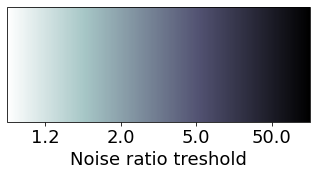

In [321]:
divider = make_axes_locatable(axes)
cax = divider.append_axes('right', size='5%', pad=0.05)

a = np.array([[0,1,2,3,4,5,6,7,8]])
img = cax.imshow(a, cmap='bone_r')
plt.gca().set_visible(False)
cax = plt.axes([0, 10, 0.7, 0.4])
fig.colorbar(img, orientation="horizontal", cax=cax)
locs, labels = plt.xticks()
cax.set_xticks([1,3,5,7], ['1.2','2.0','5.0','50.0'])
cax.set_xlabel('Noise ratio treshold')

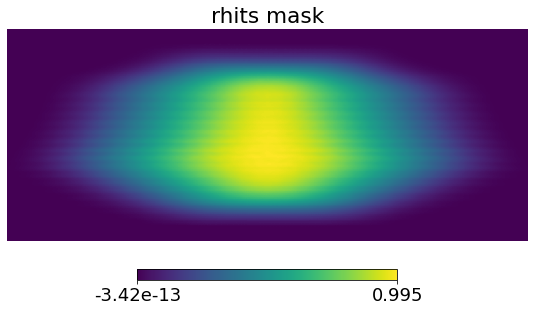

In [34]:
ratio = 4
tresh = np.where(rhits < 1. / ratio, 0., 1.)  *(~np.isnan(rhits))
proj_map = hp.cartview(cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, title='rhits mask', rot=[-rotation,-rotation], return_projected_map=True)
# hp.cartview(tresh, lonra=lonra+rotation, latra=latra+rotation, title='treshold rhits mask', rot=[-rotation,-rotation], norm='hist', return_projected_map=True)
# hp.cartview(cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, title='cmbs4 mask', rot=[-rotation,-rotation], norm='hist')
# hp.mollview(cmbs4_mask, title='cmbs4 mask', norm='hist')

[-15  95] [-75 -30]


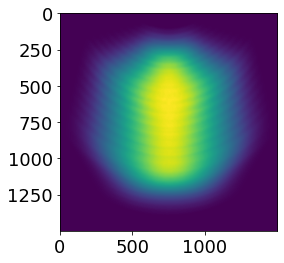

In [68]:
Nptsx = 1500
Nptsy = 1000
print(lonra, latra)
lcell_amin = 2.7
_lonra = [-lcell_amin * Nptsx / 60. / 2., lcell_amin / 60 * Nptsx / 2.]
_latra = [-lcell_amin * Nptsy / 60  / 2., lcell_amin / 60 * Nptsy / 2.]
P = CartesianProj(rot = [np.mean(lonra),np.mean(latra),0.], lonra=_lonra, latra=_latra, xsize=Npts, ysize=Npts)
P.set_flip('astro')
projmap = P.projmap(cmbs4_mask, lambda x, y, z: hp.vec2pix(hp.npix2nside(len(hpmap)), x, y, z))
plt.imshow(projmap)

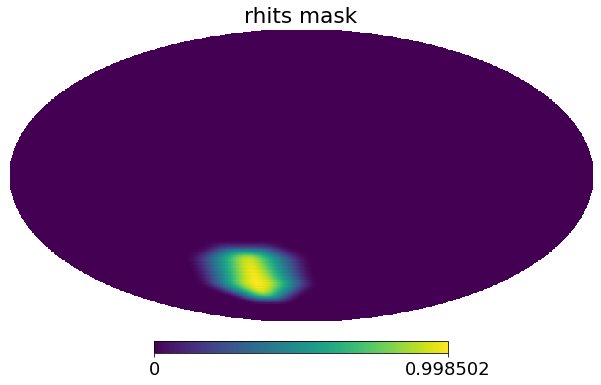

In [40]:
hp.mollview(rhits, title='rhits mask')

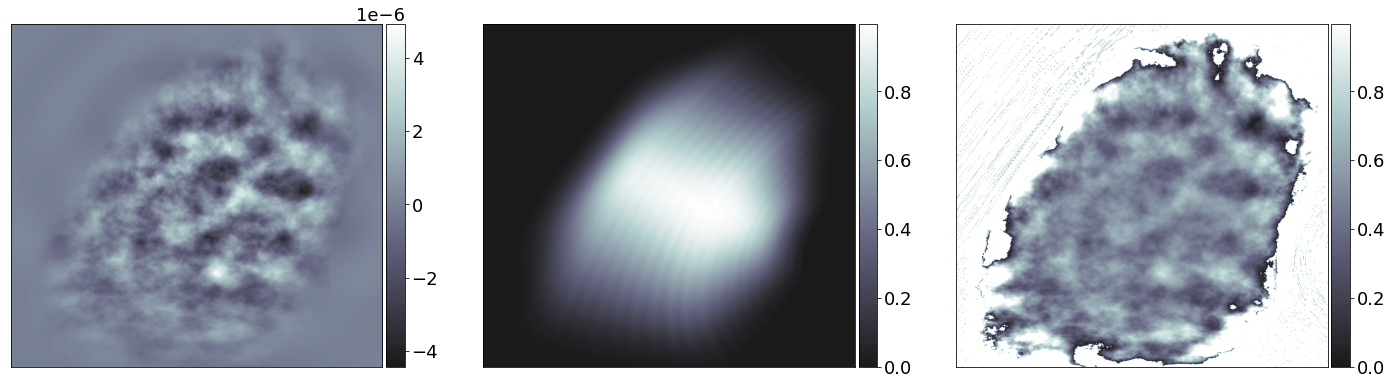

In [229]:
fig, axes = plt.subplots(1, 3, figsize=(24, 8))
for ax in axes:
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
im = axes[0].imshow(noisemap, alpha=0.9, origin='lower', cmap='bone')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im = axes[1].imshow(proj_map, alpha=0.9, origin='lower', cmap='bone')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

imgplot = axes[2].imshow(np.where(np.abs(noisemap/proj_map)>1e-5,1e-5,noisemap/proj_map), alpha=0.9, origin='lower', cmap='bone')
divider = make_axes_locatable(axes[2])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

## EB maps

In [22]:
simidx = 0
bpl, bpu = 30, 200
rotation = 0
lonra = np.array([-55,55])+40
latra = np.array([-100,-55])+25
minmax = 0.2
fg_loc = '00'

In [36]:
blm_lensc = hp.read_alm(getfn_blm_lensc(simidx, fg_loc, 12))
bmap_lensc = hp.alm2map(blm_lensc, 2048)
bmap_lensc_bp = hp.alm2map(bandpass_alms(blm_lensc,bpl,bpu), 2048)

In [35]:
blmQE_lensc = np.load(getfn_blm_lensc(simidx, fg_loc, 0))
bmapQE_lensc = hp.alm2map(blmQE_lensc, 2048)
bmapQE_lensc_bp = hp.alm2map(bandpass_alms(blmQE_lensc,bpl,bpu), 2048)

In [32]:
qumap_cs = getfn_qumap_cs(simidx)
eblm_cs = hp.map2alm_spin(qumap_cs*cmbs4_mask, 2, 2048)

bmap_cs = hp.alm2map(eblm_cs[1], 2048)
bmap_cs_bp = hp.alm2map(bandpass_alms(eblm_cs[1],bpl,bpu), 2048)

### Wiener-filtered ILC B

In [11]:
ninv = cinv_p_OBD_nobmarg.chain.n_inv_filt.n_inv[0]
bwflm = ivfs_OBD.get_sim_bmliklm(0) # b maximum likelihood lm
bwfmap = hp.alm2map(bwflm, nside=2048)

bwf_bp = hp.alm2map(bandpass_alms(bwflm,bpl,bpu), 2048)
clbwf = hp.alm2cl(bwflm)

2048 2048


In [24]:
bwflm = np.load('/global/cscratch1/sd/sebibel/cmbs4/s08b/cILC2021_%s_lmax4000/zb_terator_p_p_%04d_nofg_OBD_solcond_3apr20/ffi_p_it0/bwflm_%04d.npy'%(fg,simidx,simidx))
bwfmap = hp.alm2map(bwflm, nside=2048)
bwf_bp = hp.alm2map(bandpass_alms(bwflm,bpl,bpu), 2048)
clbwf = hp.alm2cl(bwflm)

(2.0, 500.0)

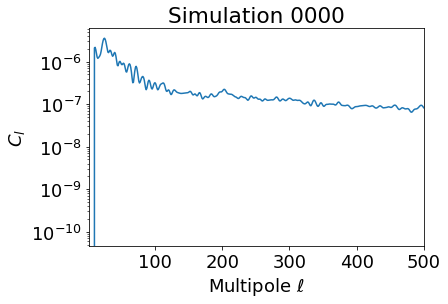

In [25]:
plt.plot(clbwf, label='B^{WF}')
plt.title('Simulation 0000')
plt.xlabel("Multipole $\ell$")
plt.ylabel("$C_l$")
plt.yscale('log')
plt.xlim(2,500)

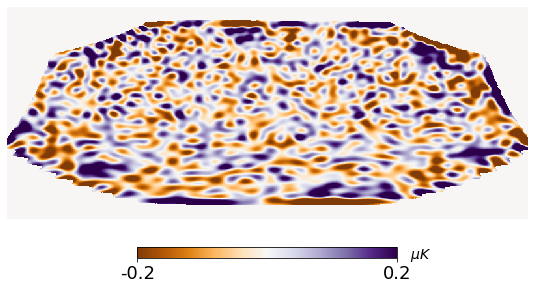

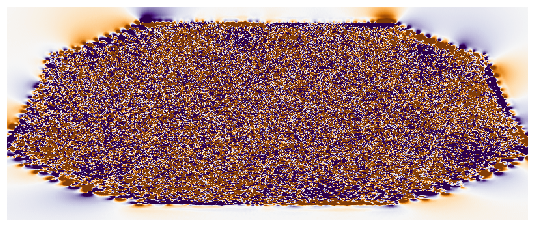

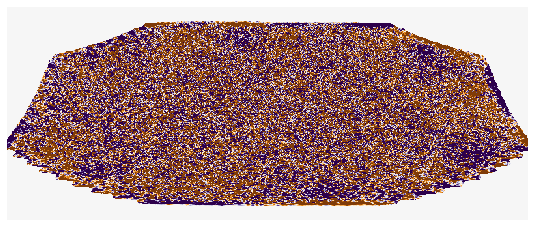

In [44]:
hp.cartview(bwf_bp*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=True, unit=r'$\mu K$', min=-minmax, max=minmax,
            title='')
hp.cartview(bwfmap, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, unit=r'$\mu K$', min=-minmax, max=minmax,
            title='')
hp.cartview(bwfmap, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, unit=r'$\mu K$', min=-minmax, max=minmax,
            title='')

### Plot

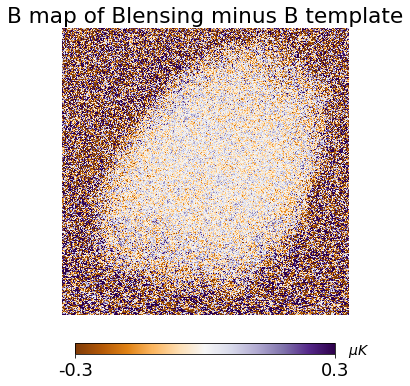

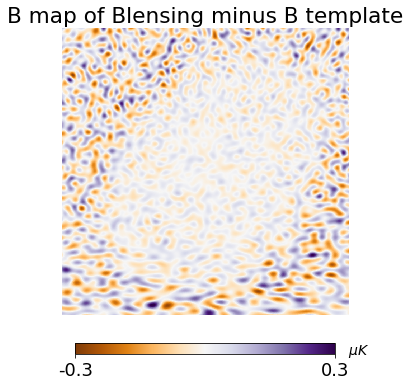

In [20]:
hp.cartview(hp.alm2map(blm_L[0], 2048) - bmap_lensc, lonra=lonra+rotation, latra=latra+rotation, min=-minmax, max=minmax, unit=r'$\mu K$', cmap='PuOr', title='B map of Blensing minus B template', rot=[-rotation,-rotation])
hp.cartview(hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmap_lensc_bp, lonra=lonra+rotation, latra=latra+rotation, min=-minmax, max=minmax, unit=r'$\mu K$', cmap='PuOr', title='B map of Blensing minus B template', rot=[-rotation,-rotation])

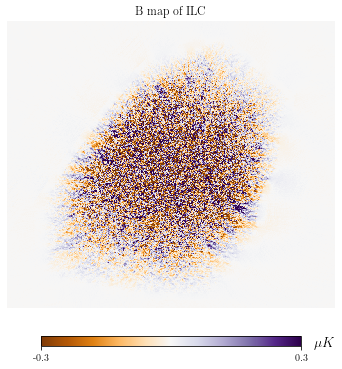

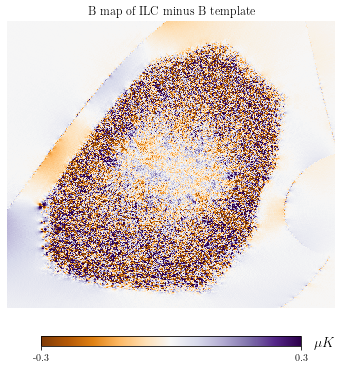

In [368]:
hp.cartview(bmap_cs, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max= minmax, unit=r'$\mu K$', title='B map of ILC', rot=[-rotation,-rotation])
hp.cartview((bmap_cs - bmap_lensc), lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, unit=r'$\mu K$', max= minmax, title='B map of ILC minus B template', rot=[-rotation,-rotation])

### ILC version

NameError: name 'bmap_cs_bp' is not defined

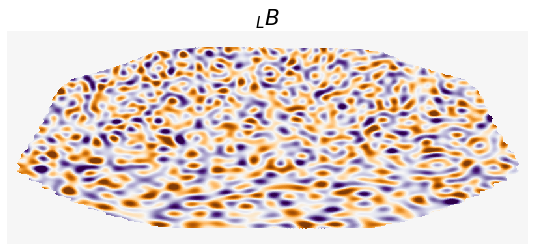

In [38]:
minmax=0.2
hp.cartview(hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='$_LB$')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens_map.pdf', bbox_inches='tight')

hp.cartview(bmap_cs_bp*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='$_CB$')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BILC_map.pdf', bbox_inches='tight')

hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmapQE_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation,rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max= minmax, unit=r'$\mu K$', 
            title='$_LB-B^{temp, QE}$')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens-BtempQE_map.pdf', bbox_inches='tight')

hp.cartview((bmap_cs_bp - bmapQE_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='$_CB-B^{temp, QE}$')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BILC-BtempQE_map.pdf', bbox_inches='tight')

hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmap_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max= minmax, unit=r'$\mu K$',
            title='$_LB-B^{temp, MAP}$')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens-BtempMAP_map.pdf', bbox_inches='tight')

hp.cartview((bmap_cs_bp - bmap_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='$_CB-B^{temp, MAP}$')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BILC-BtempMAP_map.pdf', bbox_inches='tight')

NameError: name 'bmap_cs_bp' is not defined

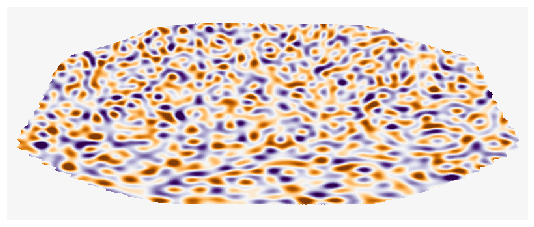

In [31]:
minmax=0.2
hp.cartview(hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens_map_notitle.pdf', bbox_inches='tight')

hp.cartview(bmap_cs_bp*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BILC_map_notitle.pdf', bbox_inches='tight')

hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmapQE_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation,rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max= minmax, unit=r'$\mu K$', 
            title='')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens-BtempQE_map_notitle.pdf', bbox_inches='tight')

hp.cartview((bmap_cs_bp - bmapQE_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BILC-BtempQE_map_notitle.pdf', bbox_inches='tight')

hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmap_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max= minmax, unit=r'$\mu K$',
            title='')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens-BtempMAP_map_notitle.pdf', bbox_inches='tight')

hp.cartview((bmap_cs_bp - bmap_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BILC-BtempMAP_map_notitle.pdf', bbox_inches='tight')

### $B^{WF}$ version

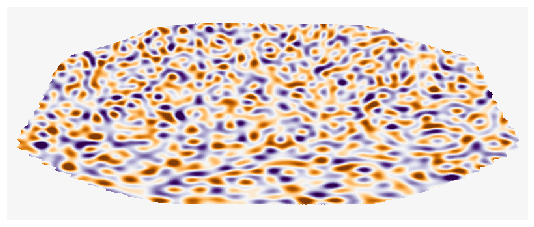

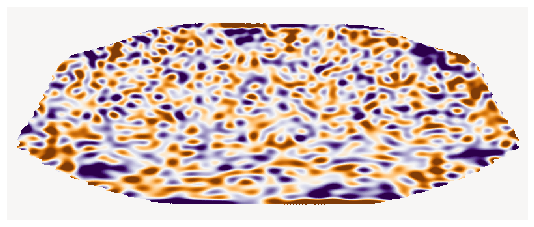

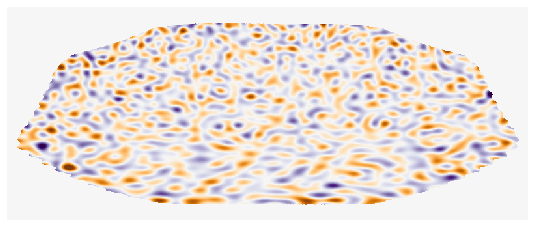

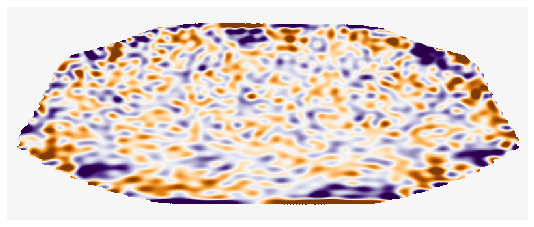

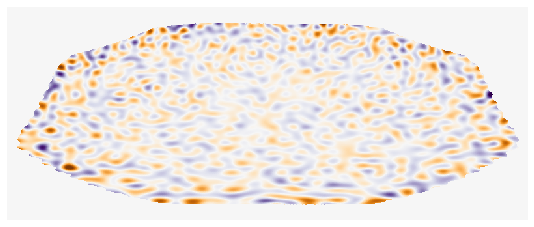

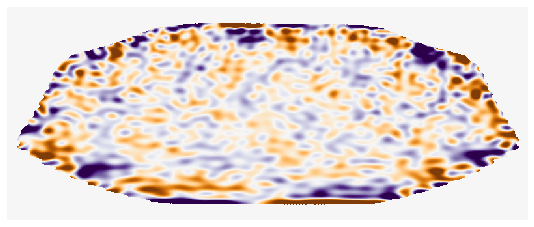

In [41]:
minmax=0.2
hp.cartview(hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$', title=None)
# ,title='$_LB$')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens_map.pdf', bbox_inches='tight')

hp.cartview(bwf_bp*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$', title=None)
# , title='$_CB^{WF}$')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BWFILC_map.pdf', bbox_inches='tight')

hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmapQE_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation,rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max= minmax, unit=r'$\mu K$', title=None)
            # , title='$_LB-B^{temp, QE}$')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens-BtempQE_map.pdf', bbox_inches='tight')

hp.cartview((bwf_bp - bmapQE_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$', title=None)
            # , title='$_CB^{WF}-B^{temp, QE}$')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BWFILC-BtempQE_map.pdf', bbox_inches='tight')

hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmap_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max= minmax, unit=r'$\mu K$', title=None)
            # , title='$_LB-B^{temp, MAP}$')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens-BtempMAP_map.pdf', bbox_inches='tight')

hp.cartview((bwf_bp - bmap_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$', title=None)
            # , title='$_CB^{WF}-B^{temp, MAP}$')
# plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BWFILC-BtempMAP_map.pdf', bbox_inches='tight')

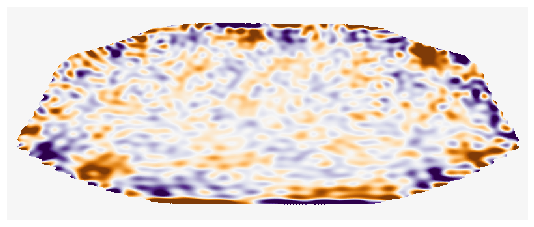

In [42]:
hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048)-bwf_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$', title=None)

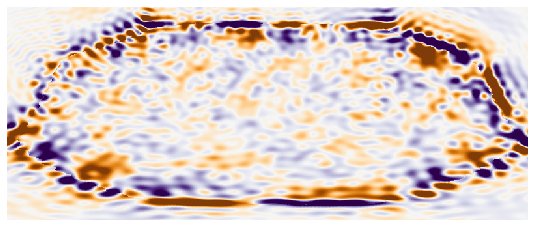

In [50]:
hp.cartview(hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048)*int_mask-bwf_bp, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='')

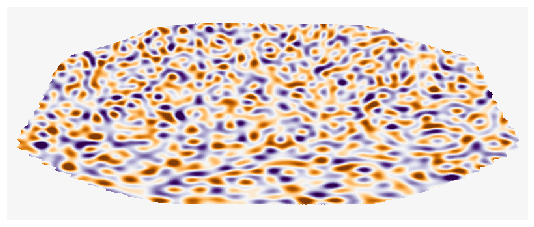

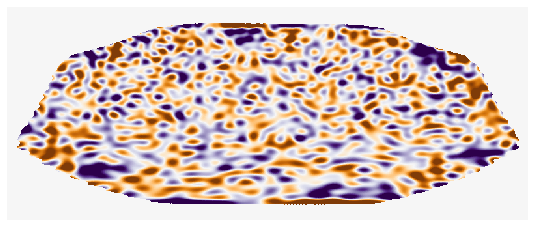

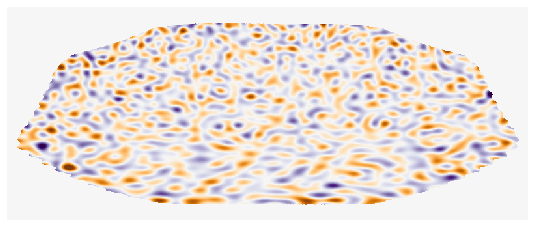

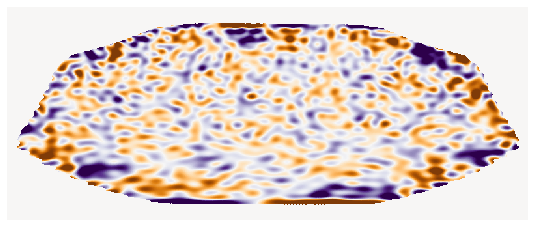

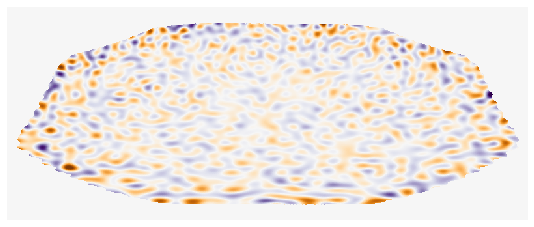

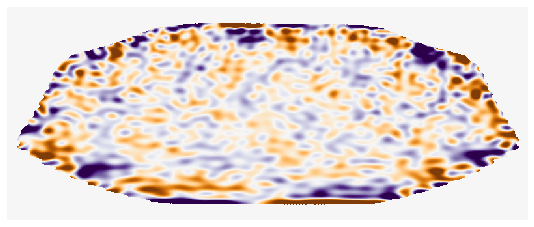

In [48]:
minmax=0.2
hp.cartview(hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens_map_notitle.pdf', bbox_inches='tight')

hp.cartview(bwf_bp*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BWFILC_map_notitle.pdf', bbox_inches='tight')

hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmapQE_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation,rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max= minmax, unit=r'$\mu K$', 
            title='')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens-BtempQE_map_notitle.pdf', bbox_inches='tight')

hp.cartview((bwf_bp - bmapQE_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BWFILC-BtempQE_map_notitle.pdf', bbox_inches='tight')

hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmap_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max= minmax, unit=r'$\mu K$',
            title='')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/Blens-BtempMAP_map_notitle.pdf', bbox_inches='tight')

hp.cartview((bwf_bp - bmap_lensc_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/BWFILC-BtempMAP_map_notitle.pdf', bbox_inches='tight')

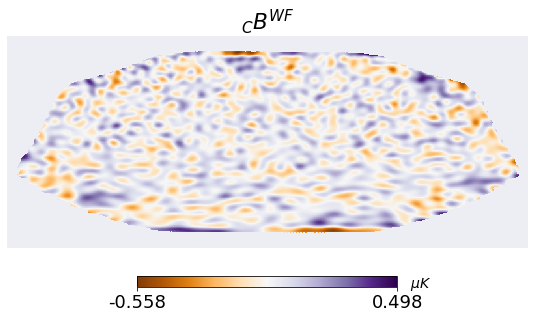

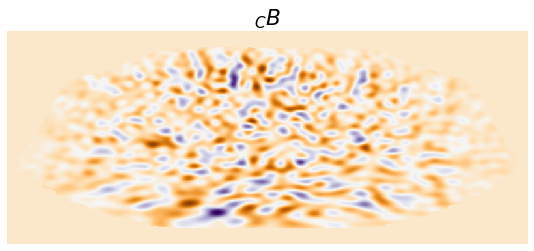

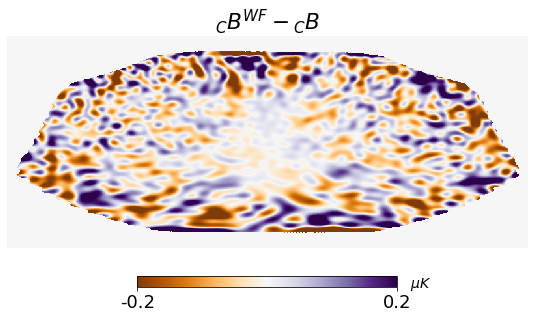

In [107]:
hp.cartview(bwf_bp*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=True, unit=r'$\mu K$',
            title='$_CB^{WF}$')
hp.cartview(bmap_cs_bp*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, unit=r'$\mu K$',
            title='$_CB$')
hp.cartview((bwf_bp-bmap_cs_bp)*int_mask, lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=True, min=-minmax, max=minmax, unit=r'$\mu K$',
            title='$_CB^{WF}-_CB$')

### Colorbar

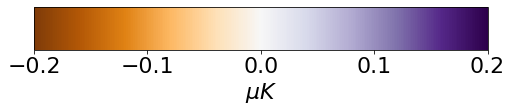

In [410]:
matplotlib.rcParams.update({'font.size': 22})
a = np.array([[-0.2,0.2]])
plt.figure(figsize=(9, 1.5))
img = plt.imshow(a, cmap='PuOr')
plt.gca().set_visible(False)
cax = plt.axes([-0, 10, 0.7, 0.4])
plt.colorbar(orientation="horizontal", cax=cax)
plt.xlabel('$\mu K$')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/cbar.pdf', bbox_inches='tight')

## QU maps

In [29]:
rotation = 0
lonra = np.array([-55,55])+40
latra = np.array([-100,-55])+25
bpl,bpu = 30,200
minmax = 0.3
fg_loc = '00'

In [27]:
simidx = 0
elm_L = np.zeros(shape=(len([0]),hp.Alm.getsize(lmax_cl)), dtype=np.cdouble)
blm_L = np.zeros(shape=(len([0]),hp.Alm.getsize(lmax_cl)), dtype=np.cdouble)
elm_L[0] = hp.almxfl(utils.alm_copy(planck2018_sims.cmb_len_ffp10.get_sim_elm(simidx), lmax=lmax_cl), transf)
blm_L[0] = hp.almxfl(utils.alm_copy(planck2018_sims.cmb_len_ffp10.get_sim_blm(simidx), lmax=lmax_cl), transf)
# bcl_L = np.array([hp.alm2cl(blm_L[simidx]) for simidx in range(len(simids))])

In [32]:
Q_ffp10, U_ffp10 = hp.alm2map_spin((elm_L[0], blm_L[0]), 2048, 2, hp.Alm.getlmax(elm_L.size))
Q_ffp10_bp, U_ffp10_bp = hp.alm2map_spin((bandpass_alms(elm_L[0],bpl,bpu), bandpass_alms(blm_L[0],bpl,bpu)), 2048, 2, hp.Alm.getlmax(elm_L.size))

In [33]:
blm_lensc = hp.read_alm(getfn_blm_lensc(simidx, fg_loc, 12))
Q_lensc, U_lensc = hp.alm2map_spin((np.zeros_like(blm_lensc), blm_lensc), 2048, 2, hp.Alm.getlmax(blm_lensc.size))
Q_lensc_bp, U_lensc_bp = hp.alm2map_spin((np.zeros_like(blm_lensc), bandpass_alms(blm_lensc,bpl,bpu)), 2048, 2, hp.Alm.getlmax(blm_lensc.size))

In [34]:
qumap_cs = getfn_qumap_cs(simidx)

eblm_cs = hp.map2alm_spin(qumap_cs*cmbs4_mask,2,2048)
elm_bp = bandpass_alms(eblm_cs[0],bpl,bpu)
blm_bp = bandpass_alms(eblm_cs[1],bpl,bpu)
qumap_cs_bp = hp.alm2map_spin([elm_bp,blm_bp],2048,2,2048)

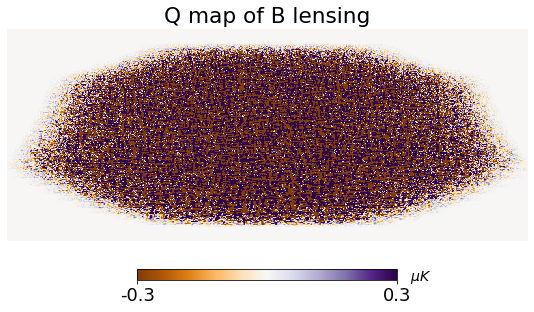

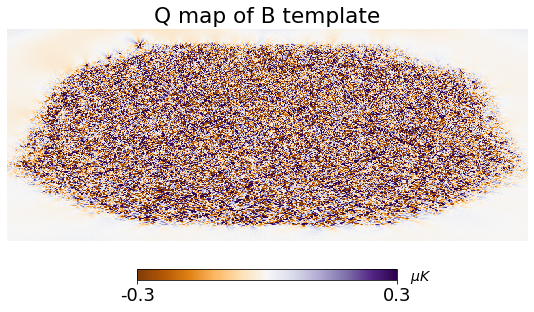

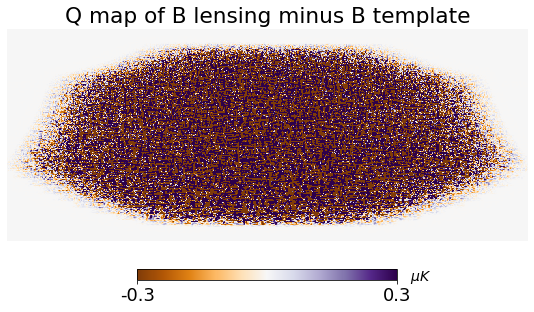

In [35]:
hp.cartview(Q_ffp10*cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of B lensing', rot=[-rotation,-rotation])
hp.cartview(Q_lensc, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of B template', rot=[-rotation,-rotation])
hp.cartview((Q_ffp10-Q_lensc)*cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of B lensing minus B template', rot=[-rotation,-rotation])

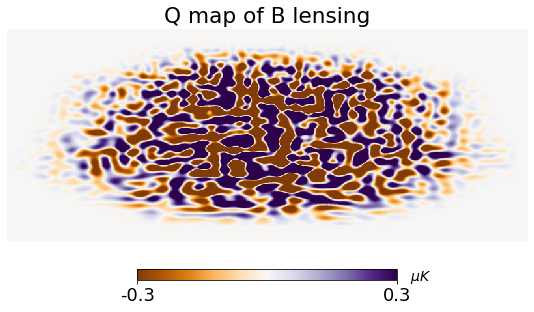

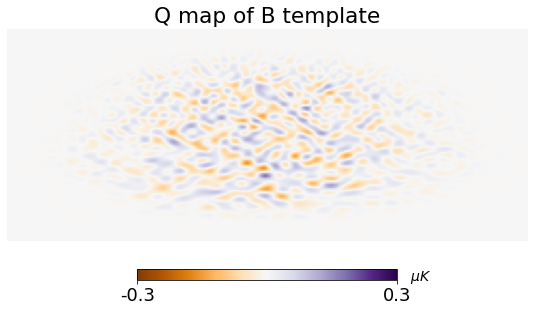

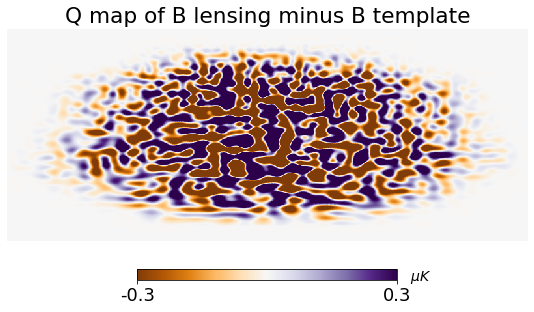

In [36]:
hp.cartview(Q_ffp10_bp*cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of B lensing', rot=[-rotation,-rotation])
hp.cartview(Q_lensc_bp*cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of B template', rot=[-rotation,-rotation])
hp.cartview((Q_ffp10_bp-Q_lensc_bp)*cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of B lensing minus B template', rot=[-rotation,-rotation])

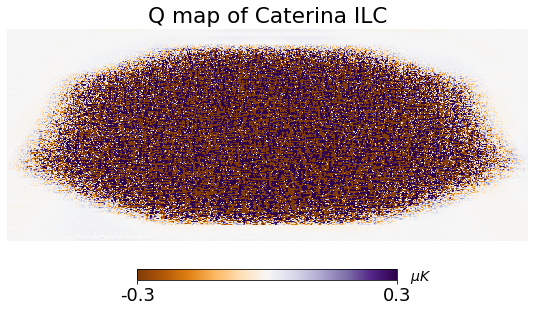

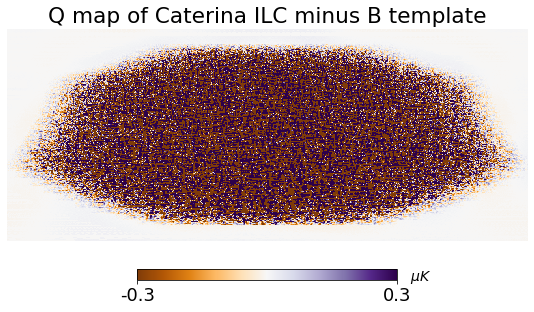

In [38]:
hp.cartview(qumap_cs[0]*cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of Caterina ILC', rot=[-rotation,-rotation])
hp.cartview((qumap_cs[0]-Q_lensc)*cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of Caterina ILC minus B template', rot=[-rotation,-rotation])

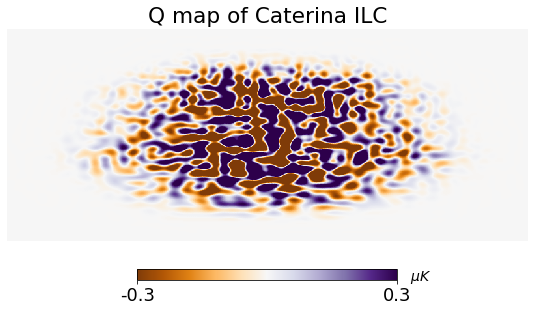

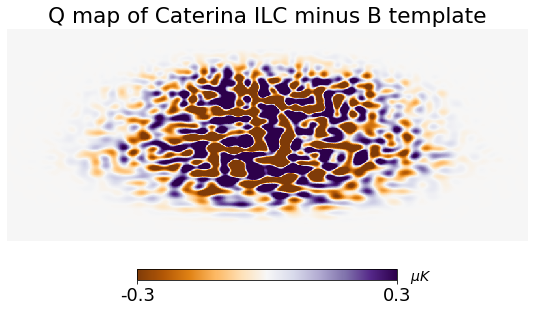

In [39]:
hp.cartview(qumap_cs_bp[0]*cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of Caterina ILC', rot=[-rotation,-rotation])
hp.cartview((qumap_cs_bp[0]-Q_lensc_bp)*cmbs4_mask, lonra=lonra+rotation, latra=latra+rotation, cmap='PuOr', min=-minmax, max=minmax, unit=r'$\mu K$', title='Q map of Caterina ILC minus B template', rot=[-rotation,-rotation])

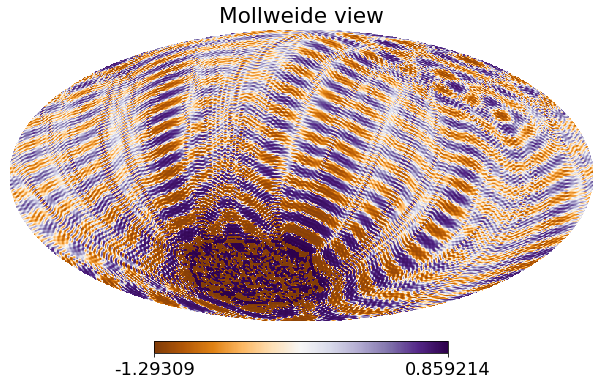

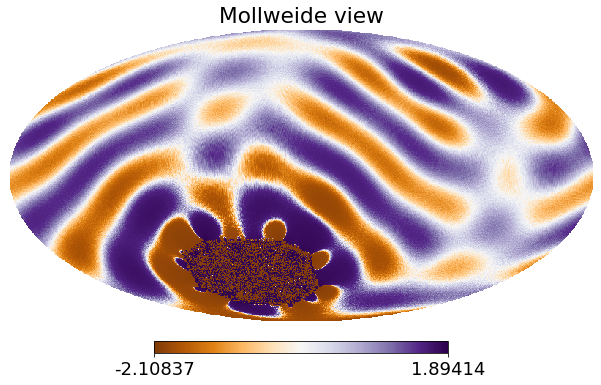

In [87]:
hp.mollview(bwf_bp, cmap='PuOr', norm='hist')
hp.mollview(bwfmap, cmap='PuOr', norm='hist')

# Other

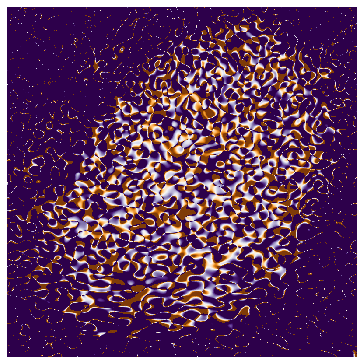

In [29]:
hp.cartview((hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048) - bmap_lensc_bp)/hp.alm2map(bandpass_alms(blm_L[0],bpl,bpu), 2048), lonra=lonra+rotation, latra=latra+rotation, rot=[-rotation,-rotation],
            cmap='PuOr', cbar=False, min=-minmax, max= minmax, unit=r'$\mu K$',
            title='')
plt.savefig('/global/homes/s/sebibel/notebooks/CMBS4/plots/blens_tshirt.png', bbox_inches='tight')